In [19]:
# data access
import json
import os, glob
import pickle

# data processing
import numpy as np
import pandas as pd
from itertools import cycle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ROC AUC curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# import utility plots
from utility import plot_learning_curves, plot_confusion_matrix, plot_roc_over_epochs
from sklearn.metrics import multilabel_confusion_matrix, classification_report

ImportError: cannot import name 'multilabel_confusion_matrix'

In [20]:
sns.set(style="darkgrid", font_scale=1.5)

In [21]:
experiments_dir = "experiments"

# Define helper functions

In [31]:
def generate_dir_hist(experiment, experiments_dir=experiments_dir):
    output_dir = os.path.join(experiments_dir,experiment)
    plot_dir = os.path.join(output_dir,"plots")
    history_filepath = os.path.join(output_dir,"history.pkl")
    model_name = experiment.split("_")[0]

    # make plots folder
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # open pickled history
    with open(history_filepath, 'rb') as file:
        hist_exp = pickle.load(file)
    return(hist_exp,model_name,plot_dir,output_dir)

In [32]:
def generate_dir_testscores(experiment, experiments_dir=experiments_dir):
    output_dir = os.path.join(experiments_dir,experiment)
    plot_dir = os.path.join(output_dir,"plots")
    history_filepath = os.path.join(output_dir,"history.pkl")
    model_name = experiment.split("_")[0]

    # make plots folder
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # open pickled history
    with open(history_filepath, 'rb') as file:
        hist_exp = pickle.load(file)
    class_names = list(hist_exp['auroc'].keys())
        
    df_test_y_true = pd.read_csv(os.path.join(output_dir,"test_y_true.csv"), usecols=[i+1 for i in range(len(class_names))])
    df_test_y_true.columns = class_names
    
    df_test_y_score = pd.read_csv(os.path.join(output_dir,"test_y_score.csv"), usecols=[i+1 for i in range(len(class_names))])
    df_test_y_score.columns = class_names
    return(df_test_y_true,df_test_y_score,class_names,model_name,plot_dir,output_dir)

In [33]:
def generate_loss_curves(model_name, plot_dir, hist_exp, max_epoch = 50):
    # Loss Curves
    curve_type = "Loss"
    plot_title = "{} - {} Curve".format(model_name,curve_type)

    train_list = hist_exp['history']['loss']
    valid_list = hist_exp['history']['val_loss']
    epoch_list = [i + 1 for i in range(len(train_list))]

    df_train = pd.DataFrame([epoch_list, train_list], index=["epoch",curve_type]).T
    df_train["type"] = "train"

    df_valid = pd.DataFrame([epoch_list, valid_list], index=["epoch",curve_type]).T
    df_valid["type"] = "validation"

    # get only until epoch 50
    df_curves = pd.concat([df_train, df_valid])
#     df_curves = df_curves[df_curves['epoch'] <= max_epoch]
    
    plt.figure()
    sns.lineplot(data=df_curves, x="epoch", y=curve_type,hue="type")
    plt.title(plot_title)
    plt.xlabel("Epoch")
    plt.ylabel(curve_type)
    plt.ylim(0.15,0.23)
    plt.legend(loc="best")
    plt.xlim(0,max_epoch)
    
    # save the plot
    plot_filename = os.path.join(plot_dir,"{}.png".format(plot_title))
    plt.tight_layout()
    plt.savefig(plot_filename)

In [34]:
def generate_lr_curve(model_name, plot_dir, hist_exp, max_epoch = 50):
    lr_list = hist_exp['history']['lr']
    epoch_list = [i+1 for i in range(len(lr_list))]

    curve_type = "Learning Rate"
    plot_title = "{} - {} Curve".format(model_name,curve_type)

    plt.figure()
    sns.lineplot(y=lr_list, x=epoch_list)
    plt.title(plot_title)
    plt.xlabel("Epoch")
    plt.ylabel(curve_type)
    plt.xlim(0,max_epoch)

    # save the plot
    plot_filename = os.path.join(plot_dir,"{}.png".format(plot_title))
    plt.tight_layout()
    plt.savefig(plot_filename)

In [35]:
def generate_test_auroc(df_test_y_true,df_test_y_score,class_names,model_name,plot_dir, test_auroc):
    n_classes = len(class_names)
    y_test = df_test_y_true.values
    y_score = df_test_y_score.values

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[class_name] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    test_auroc[model_name] = roc_auc

    curve_type = "Test AUC ROC"
    plot_title = "{} - {} Curve".format(model_name,curve_type)

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average (auroc={0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='red', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average (auroc={0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='black', linewidth=4)

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(sns.color_palette(n_colors=7))
    for i, color in zip(range(int(n_classes/2)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='{0} (auroc={1:0.2f})'.format(class_names[i], roc_auc[class_names[i]]))

    for i, color in zip(range(int(n_classes/2),n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=3, linestyle=":",
                 label='{0} (auroc={1:0.2f})'.format(class_names[i], roc_auc[class_names[i]]))

    plt.plot([0, 1], [0, 1], lw=1, color="gray")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="right", ncol=1, fontsize='x-small',bbox_to_anchor=(1.65,0.5))

    # save the plot
    plot_filename = os.path.join(plot_dir,"{}.png".format(plot_title))
    plt.savefig(plot_filename,bbox_inches='tight')
    
    return(test_auroc)

In [36]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

# Learning / Epoch curves

In [37]:
experiment_folders = [exp.split("\\")[-1] for exp in glob.glob(os.path.join(experiments_dir,"*")) if ('-50' in exp) or ('-100' in exp)]

In [38]:
experiment_folders

['densenet121_sample-5pct_epochs-100', 'resnet50_sample-5pct_epochs-50']

## using seaborn

NameError: name 'generate_auroc_curve' is not defined

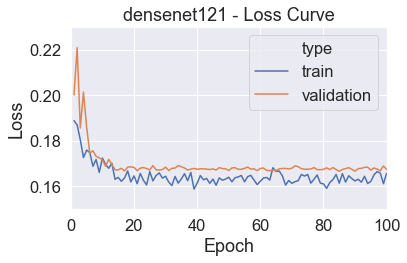

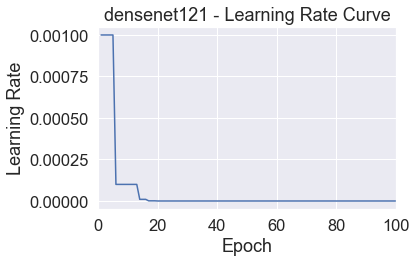

In [40]:
for experiment in experiment_folders:
    # extract info
    hist_exp,model_name,plot_dir,output_dir = generate_dir_hist(experiment, experiments_dir=experiments_dir)
    
    # plot epoch curves
    generate_loss_curves(model_name, plot_dir, hist_exp)
    if "lr" in hist_exp["history"].keys():
        generate_lr_curve(model_name, plot_dir, hist_exp)
    generate_auroc_curve(model_name, plot_dir, hist_exp)
    
    # plot test confusion matrix and AUROC results

## using matplotlib

================= densenet121_sample-5pct_epochs-100 =================
================= resnet50_sample-5pct_epochs-50 =================


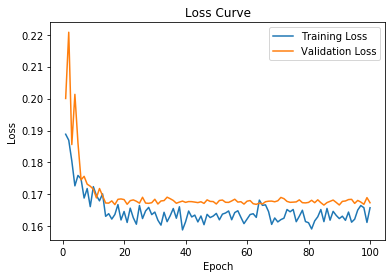

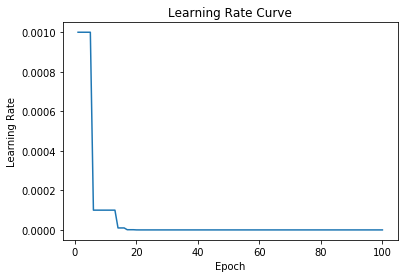

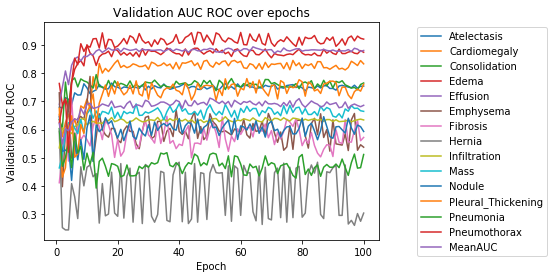

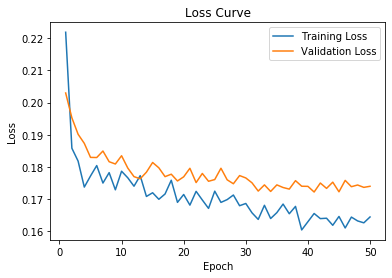

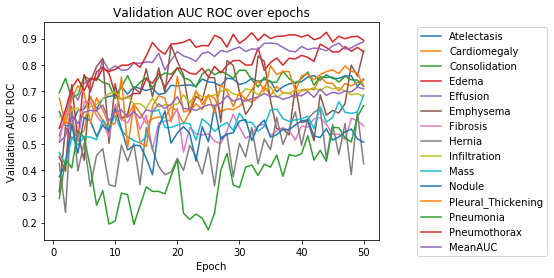

In [5]:
for experiment in experiment_folders:
    print("================= {} =================".format(experiment))
    # experiment = "densenet121_sample-5pct_epochs-5"
    output_dir = os.path.join(experiments_dir,experiment)
    plot_dir = os.path.join(output_dir,"plots")
    history_filepath = os.path.join(output_dir,"history.pkl")

    # make plots folder
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # open pickled history
    with open(history_filepath, 'rb') as file:
        hist_exp = pickle.load(file)

    # generate training curves and AUROC over epochs
    plot_learning_curves(plot_dir, "Loss", hist_exp['history']['loss'], hist_exp['history']['val_loss'])
    if "densenet121" in experiment:
        plot_learning_curves(plot_dir, "Learning Rate", hist_exp['history']['lr'], [], valid=False)
    plot_roc_over_epochs(plot_dir, hist_exp['auroc'])

# Test AUC ROC plots

## AUC ROC curves

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [431]:
test_auroc = {}

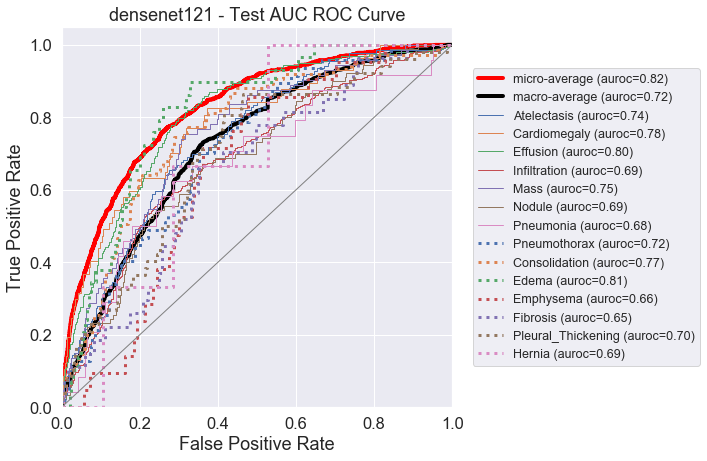

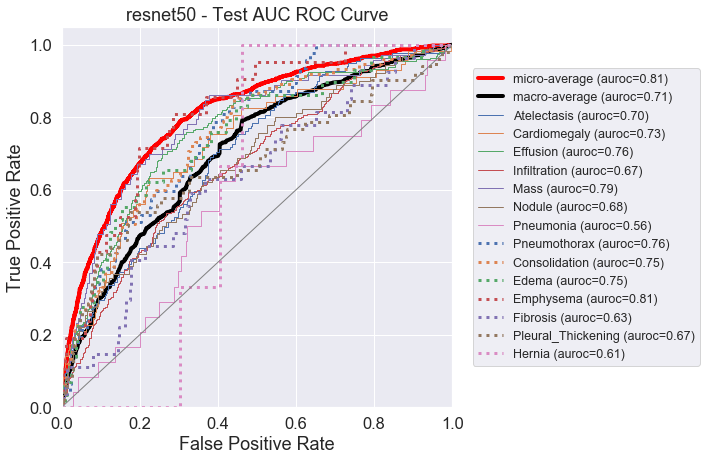

In [432]:
for experiment in experiment_folders:
    df_test_y_true,df_test_y_score,class_names,model_name,plot_dir,output_dir = generate_dir_testscores(experiment, experiments_dir=experiments_dir)
    test_auroc = generate_test_auroc(df_test_y_true,df_test_y_score,class_names,model_name,plot_dir, test_auroc)

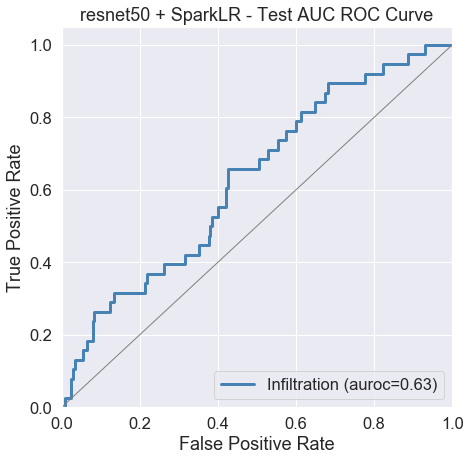

In [433]:
# extract y_scores
df_sparkdl_pred = pd.read_json(os.path.join("sample","ResNet50-LR-model-test-data.json"))
sparkdl_y_score = np.array(df_sparkdl_pred['probability'].apply(lambda x: x['values']).values.tolist())
sparkdl_y_score_list = pd.DataFrame([df_sparkdl_pred.index, sparkdl_y_score[:,1]], index=["fileName", "y_score"]).T.set_index("fileName")

# map against y_true
df_sparkdl_true = pd.read_csv(os.path.join("sample","ResNet50-LR-model-predictions.csv"))
sparkdl_y_true_list = df_sparkdl_true[["fileName","Infiltration"]].rename(columns={"Infiltration":"y_true"}).set_index("fileName")

# merge based on fileName
df_sparkdl = sparkdl_y_score_list.join(sparkdl_y_true_list).dropna(how='any')
y_score = df_sparkdl['y_score'].values
y_test = df_sparkdl['y_true'].values

# Compute ROC curve and area the curve
model_name = "resnet50 + SparkLR"
curve_type = "Test AUC ROC"
plot_title = "{} - {} Curve".format(model_name,curve_type)

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
test_auroc[model_name] = {"Infiltration":roc_auc}

# plot
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, lw=3, color="steelblue",
         label='Infiltration (auroc=%0.2f)' % (roc_auc))

plt.plot([0, 1], [0, 1], lw=1, color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(plot_title)
plt.legend(loc="lower right")

# save the plot
plot_filename = os.path.join(experiments_dir,"{}.png".format(plot_title))
plt.savefig(plot_filename,bbox_inches='tight')

## AUC Heatmaps

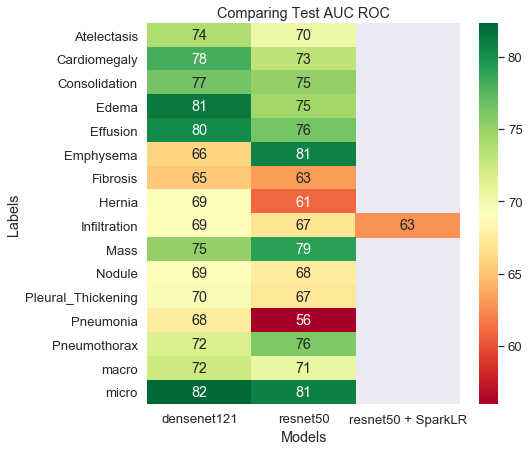

In [471]:
df_test_auroc = pd.DataFrame(test_auroc)
df_test_auroc.to_csv(os.path.join(experiments_dir,"all_experiments_test_auroc.csv"))

curve_type = "Test AUC ROC"
plot_title = "Comparing {}".format(curve_type)

sns.set(font_scale=1.2)
plt.figure(figsize=(7,7))
sns.heatmap(df_test_auroc*100, annot=True,cmap="RdYlGn")

# fix margin spacing
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel('Models')
plt.ylabel('Labels')
plt.title(plot_title)

# save the plot
plot_filename = os.path.join(experiments_dir,"{}.png".format(plot_title))
plt.savefig(plot_filename,bbox_inches='tight')

# Confusion Matrix

C:\Users\admin\Anaconda3\envs\bd4hproject\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\admin\Anaconda3\envs\bd4hproject\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\admin\Anaconda3\envs\bd4hproject\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


                    precision    recall  f1-score   support

       Atelectasis       0.00      0.00      0.00       139
      Cardiomegaly       1.00      0.02      0.03        57
          Effusion       0.52      0.18      0.26       199
      Infiltration       0.75      0.02      0.04       308
              Mass       0.00      0.00      0.00        73
            Nodule       0.00      0.00      0.00        90
         Pneumonia       0.00      0.00      0.00        24
      Pneumothorax       0.00      0.00      0.00        47
     Consolidation       0.00      0.00      0.00        75
             Edema       0.00      0.00      0.00        29
         Emphysema       0.00      0.00      0.00        21
          Fibrosis       0.00      0.00      0.00        27
Pleural_Thickening       0.00      0.00      0.00        52
            Hernia       0.00      0.00      0.00         3

         micro avg       0.54      0.04      0.07      1144
         macro avg       0.16      0.0

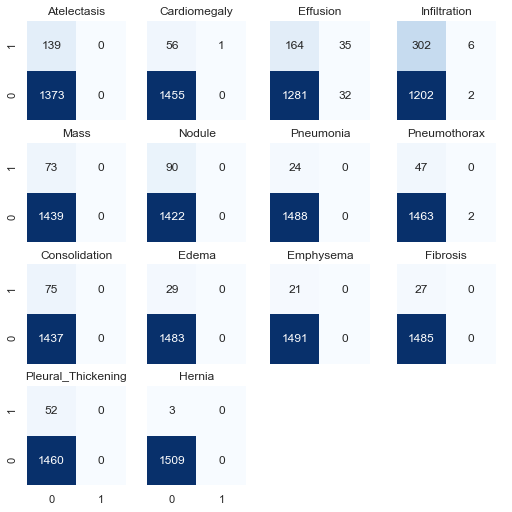

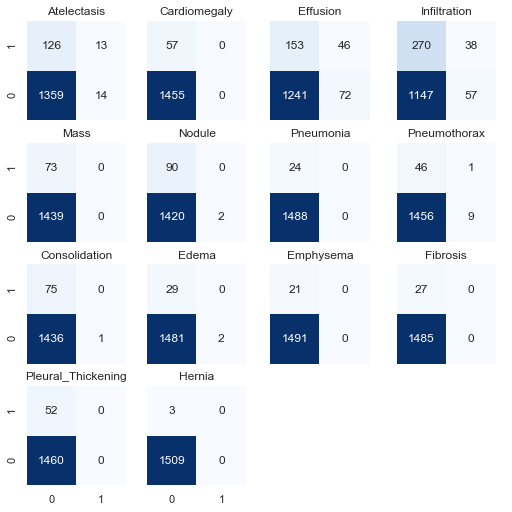

In [78]:
for experiment in experiment_folders:
    df_test_y_true,df_test_y_score,class_names,model_name,plot_dir,output_dir = generate_dir_testscores(experiment, experiments_dir=experiments_dir)

    n_classes = len(class_names)
    y_test = df_test_y_true.values
    y_score = df_test_y_score.values

    y_pred = (y_score > 0.5).astype(int)

    print(classification_report(y_test, y_pred, target_names=class_names))


    cm_list = multilabel_confusion_matrix(y_test, y_pred).tolist()

    sns.set()

    fig3, axs = plt.subplots(4, 4, figsize=(7,7), sharex='all', sharey='all', constrained_layout=True)
    axs = trim_axs(axs, len(class_names))
    for ax, class_name, cm in zip(axs, class_names, cm_list):
        sns.heatmap(cm, cbar=False, annot=True, fmt="d", square=True, cmap="Blues", ax=ax)
        ax.set_ylim(0,2)
        ax.set_title(class_name)

    plot_filename = os.path.join(plot_dir,"Multilabel Confusion Matrix.png")
    fig3.savefig(plot_filename,bbox_inches='tight')

In [71]:
# cm_list = multilabel_confusion_matrix(y_test, y_pred).tolist()

# sns.set()
# plt.figure(figsize=(7,7))

# for ix, class_name in enumerate(class_names[:9]):
#     cm = cm_list[ix]

#     plt.subplot(330+ix+1)
#     sns.heatmap(cm, cbar=False, annot=True, fmt="d", square=True, cmap="Blues")
#     plt.ylim(0,2)
#     plt.title(class_name)
#     plt.tight_layout()

In [22]:
# extract y_scores
df_sparkdl_pred = pd.read_json(os.path.join("sample","ResNet50-LR-model-test-data.json"))
sparkdl_y_score = np.array(df_sparkdl_pred['probability'].apply(lambda x: x['values']).values.tolist())
sparkdl_y_score_list = pd.DataFrame([df_sparkdl_pred.index, sparkdl_y_score[:,1]], index=["fileName", "y_score"]).T.set_index("fileName")

# map against y_true
df_sparkdl_true = pd.read_csv(os.path.join("sample","ResNet50-LR-model-predictions.csv"))
sparkdl_y_true_list = df_sparkdl_true[["fileName","Infiltration"]].rename(columns={"Infiltration":"y_true"}).set_index("fileName")

# merge based on fileName
df_sparkdl = sparkdl_y_score_list.join(sparkdl_y_true_list).dropna(how='any')
y_score = df_sparkdl['y_score'].values
y_test = df_sparkdl['y_true'].values

In [27]:
y_pred = (y_score > 0.5).astype(int)

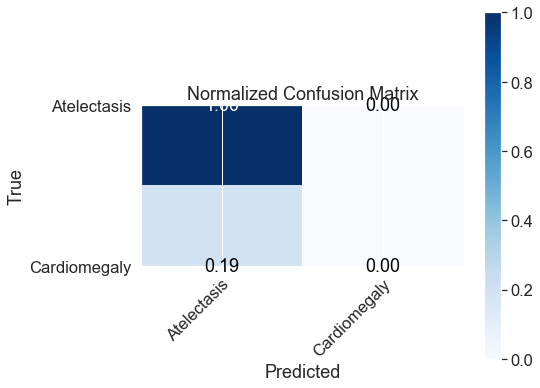

In [30]:
plot_confusion_matrix(experiments_dir, y_test, y_pred, class_names, normalized=True)

# Check Train-test split

In [13]:
counts = {}
for file in glob.glob("data/default_split/*"):
    filename = file.split("\\")[-1].split(".")[0]
    counts[filename] = {"images":pd.read_csv(file).shape[0], 
                       "patients": len(pd.read_csv(file)['Patient ID'].unique())}

In [14]:
df_counts = pd.DataFrame.from_dict(counts, orient="index")

In [16]:
df_counts/df_counts.sum()

,images,patients
dev,0.056511,0.054277
test,0.013539,0.012628
train,0.929950,0.933095


In [17]:
df_counts

,images,patients
dev,6336,1672
test,1518,389
train,104266,28744


In [101]:
(counts['train'] + counts['dev'])/df_counts.sum()

0    0.986461
dtype: float64

In [102]:
(counts['test'])/df_counts.sum()

0    0.013539
dtype: float64

In [107]:
df_counts/df_counts.sum()

,0
dev,0.056511
test,0.013539
train,0.929950


In [103]:
glob.glob("data/*")

['data\\ARXIV_V5_CHESTXRAY.pdf',
 'data\\BBox_List_2017.csv',
 'data\\cxr14_bad_labels.csv',
 'data\\Data_Entry_2017.csv',
 'data\\default_split',
 'data\\FAQ_CHESTXRAY.pdf',
 'data\\images',
 'data\\LOG_CHESTXRAY.pdf',
 'data\\README_CHESTXRAY.pdf',
 'data\\test_list.txt',
 'data\\train_val_list.txt']

In [106]:
pd.read_table('data\\test_list.txt', header=None)

,0
0,00000003_000.png
1,00000003_001.png
2,00000003_002.png
3,00000003_003.png
4,00000003_004.png
...,...
25591,00030800_000.png
25592,00030802_000.png
25593,00030803_000.png
25594,00030804_000.png


# Model Visualization

In [1]:
import numpy as np
import pandas as pd
import os
from configparser import ConfigParser
from generator import AugmentedImageSequence
from models.keras import ModelFactory
from sklearn.metrics import roc_auc_score
from utility import get_sample_counts

import pydot_ng as pydot
import graphviz

C:\Users\admin\Anaconda3\envs\chexnet-baseline\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class_names = "Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia".split(",")

In [3]:
output_dir = "./experiments/resnet50_sample-5pct_epochs-50"
base_model_name="ResNet50"

In [4]:
best_weights_path = os.path.join(output_dir, "best_weights.h5")

In [5]:
model_factory = ModelFactory()
model = model_factory.get_model(
    class_names,
    model_name=base_model_name,
    use_base_weights=False,
    weights_path=best_weights_path)

load model weights_path: ./experiments/resnet50_sample-5pct_epochs-50\best_weights.h5


In [18]:
from keras.utils import plot_model
plot_model(model, to_file=os.path.join(output_dir,"plots",'model_summary.png'), show_shapes =True)